*$\textbf{TP 2 : Expectation-Maximisation algorithm – Importance sampling}$*

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Exercise 1

## 2

In [60]:
def sample_discrete_distribution(liste_pi, liste_xi, n_samples):
    'Produces n_samples samples from a discrete distribution'
    'given the list of probabilities liste_pi and the list of values liste_xi'
    
    cumul_liste_pi = np.cumsum(liste_pi)
    uniform_samples = np.random.uniform(0, 1, n_samples)
    samples = []
    for u in uniform_samples:
        index = np.searchsorted(cumul_liste_pi, u)
        samples.append(liste_xi[index])
    return samples

## 3

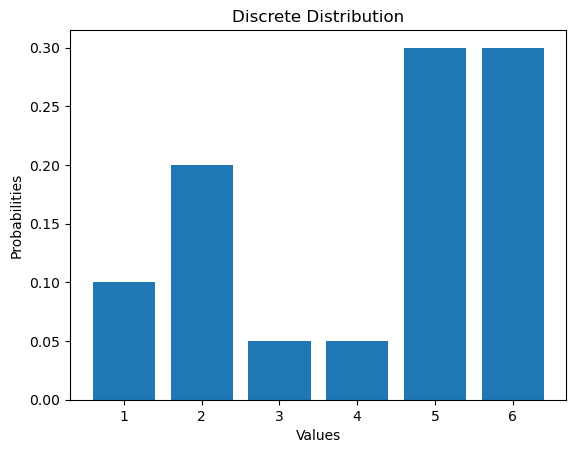

In [61]:
# Example

liste_pi = [0.1, 0.2, 0.05, 0.05, 0.3, 0.3]
liste_xi = [1, 2, 3, 4, 5, 6]

samples = sample_discrete_distribution(liste_pi, liste_xi, 10000)

plt.bar(liste_xi, liste_pi, align='center')
plt.xlabel('Values')
plt.ylabel('Probabilities')
plt.title('Discrete Distribution')
plt.show()


The empirical distribution is extremely close to the theoretical distribution of the random variable. 

# Exercise 2

In [6]:
def compute_log_likelihood(samples, liste_pi, liste_mu, liste_sigma):
    log_likelihood = 0
    n_clusters = len(liste_pi)
    for sample in samples:
        sum_likelihood = 0
        for j in range(n_clusters):
            j_likelihood = multivariate_normal.pdf(sample, mean=liste_mu[j], cov=liste_sigma[j])   
            sum_likelihood += liste_pi[j] * j_likelihood
        log_likelihood += np.log(sum_likelihood)
    return log_likelihood

## 2

In [67]:
def generate_covariance_matrix(d):
    random_matrix = np.random.rand(d, d)
    covariance_matrix = np.dot(random_matrix.T, random_matrix) + np.eye(d)
    return covariance_matrix / 2

In [75]:
def samples_GMM(n_samples, liste_pi, liste_mu, liste_sigma):
    'Sample n_samples from a Gaussian Mixture Model'
    clusters = np.array([np.random.choice(len(liste_pi), p=liste_pi) for _ in range(n_samples)])
    samples = []
    for cluster in clusters:
        samples.append(np.random.multivariate_normal(liste_mu[cluster], liste_sigma[cluster]))
    samples = np.array(samples)
    return samples, clusters

In [76]:
#Example
#Generate data
num_classes = 4
n_samples = 1500
d = 2

liste_pi = np.array(np.random.uniform(0.1, 0.5, num_classes))
liste_pi /= np.sum(liste_pi) 
liste_mu = np.array([np.random.rand(d) * 15 for _ in range(num_classes)])  
liste_sigma = np.array([generate_covariance_matrix(d) for _ in range(num_classes)])  
samples, clusters = samples_GMM(n_samples, liste_pi, liste_mu, liste_sigma)

# Assign colors based on clusters
colors = ['red', 'blue', 'green', 'yellow']
colors_samples = [colors[cluster] for cluster in clusters]

Text(0.5, 1.0, 'GMM samples and their corresponding clusters')

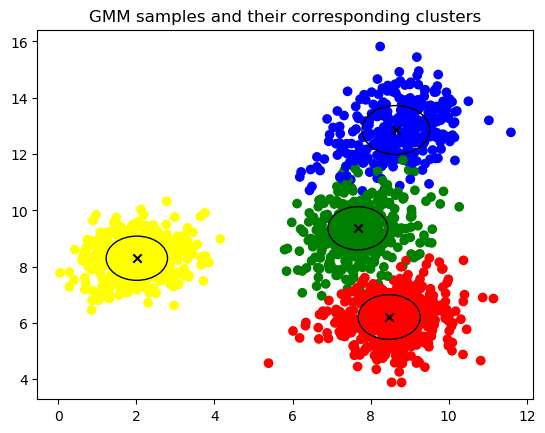

In [77]:
# Plot the samples with colors
plt.scatter([x[0] for x in samples], [x[1] for x in samples], c=colors_samples)
# Plot the means of the clusters
plt.scatter([x[0] for x in liste_mu], [x[1] for x in liste_mu], c='black', marker='x')
#plot a circle for each cluster
for i in range(num_classes):
    circle = plt.Circle(liste_mu[i], np.sqrt(liste_sigma[i][0, 0]), color='black', fill=False)
    plt.gca().add_artist(circle)
plt.title('GMM samples and their corresponding clusters')


## 3 - EM Algo and loglikelihood

In [91]:
def EM_algorithm(samples, max_iter, theta_0):
    alpha_0, mu_0, sigma_0 = theta_0[0], theta_0[1], theta_0[2]
    n_clusters = len(alpha_0)
    n_samples = len(samples)
    
    w = np.zeros((n_samples, n_clusters))

    alpha_hat = alpha_0
    mu_hat = mu_0
    sigma_hat = sigma_0
    log_likelihoods = [compute_log_likelihood(samples, alpha_hat, mu_hat, sigma_hat)]

    for _ in range(max_iter):
        # Step E
        for i in range(n_samples):
            for j in range(n_clusters):
                w[i, j] = alpha_hat[j] * multivariate_normal.pdf(samples[i], mean=mu_hat[j], cov=sigma_hat[j])
            w[i, :] /= np.sum(w[i, :])

        # Step M
        N_k = np.sum(w, axis=0)
        alpha_hat = N_k / n_samples
        mu_hat = np.dot(w.T, samples) / N_k[:, None]
        for j in range(n_clusters):
            sigma_hat[j] = np.dot(w[:, j] * (samples - mu_hat[j]).T, samples - mu_hat[j]) / N_k[j]
            sigma_hat[j] += 1e-4 * np.eye(d)
        log_likelihoods.append(compute_log_likelihood(samples, alpha_hat, mu_hat, sigma_hat))
        
    return [alpha_hat, mu_hat, sigma_hat], log_likelihoods

In [92]:
# Application of the EM algorithm for parameters estimation : 
num_classes = 4
d = 2
liste_pi = np.array(np.random.uniform(0.1, 0.5, num_classes))
liste_pi /= np.sum(liste_pi)
liste_mu = np.array([np.random.rand(d) * 15 for _ in range(num_classes)])
liste_sigma = np.array([generate_covariance_matrix(d) for _ in range(num_classes)])

samples, clusters = samples_GMM(2500, liste_pi, liste_mu, liste_sigma)

# Ground truth log-likelihood
ground_truth_theta = [liste_pi, liste_mu, liste_sigma]
ground_truth_log_likelihood = compute_log_likelihood(samples, ground_truth_theta[0], ground_truth_theta[1], ground_truth_theta[2])

# Parameters estimation
alpha_0 = np.array(np.random.uniform(0.1, 0.5, num_classes))
alpha_0 /= np.sum(alpha_0) 
mu_0 = np.array([np.random.rand(d) * 15 for _ in range(num_classes)])  
sigma_0 = np.array([generate_covariance_matrix(d) for _ in range(num_classes)])  

theta_0 = [alpha_0, mu_0, sigma_0]

theta_hat = EM_algorithm(samples, 25, theta_0)

Text(0.5, 1.0, 'Log-likelihood of the data given the parameters')

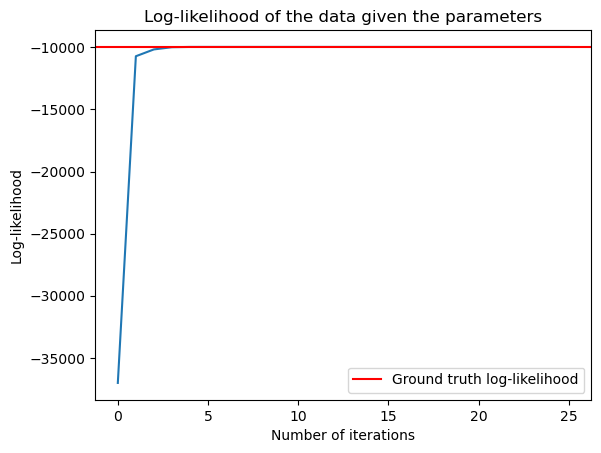

In [93]:
plt.plot(theta_hat[1])
plt.xlabel('Number of iterations')
plt.axhline(ground_truth_log_likelihood, color='red', label='Ground truth log-likelihood')
plt.ylabel('Log-likelihood')
plt.legend()
plt.title('Log-likelihood of the data given the parameters')

In [94]:
alpha, mu, sigma = theta_hat[0][0], theta_hat[0][1], theta_hat[0][2]

print('Estimated alpha:', alpha)
print('Real alpha', liste_pi)
print('\n')
print('Estimated mu:', mu)
print('Real mu', liste_mu)
print('\n')
print('Estimated sigma:', sigma)
print('Real sigma', liste_sigma)

Estimated alpha: [0.18300134 0.2076     0.2148     0.39459866]
Real alpha [0.17895456 0.40815725 0.20249125 0.21039694]


Estimated mu: [[ 9.46761731 10.22654091]
 [ 2.491788   13.49801764]
 [ 2.90093114  0.31628583]
 [13.73210226  7.58969162]]
Real mu [[ 9.53065659 10.26106917]
 [13.68749935  7.56270652]
 [ 2.79999251  0.26230749]
 [ 2.5074193  13.51744259]]


Estimated sigma: [[[1.23992865 0.32966594]
  [0.32966594 0.72677713]]

 [[0.67425062 0.27335961]
  [0.27335961 0.9525612 ]]

 [[0.87577457 0.29449029]
  [0.29449029 0.74071247]]

 [[0.85472265 0.41528122]
  [0.41528122 1.1393211 ]]]
Real sigma [[[1.22712955 0.39585019]
  [0.39585019 0.74091965]]

 [[0.8395398  0.40559078]
  [0.40559078 1.11835786]]

 [[0.88030728 0.29841468]
  [0.29841468 0.79212382]]

 [[0.69937763 0.29400299]
  [0.29400299 0.94667581]]]


In [95]:
print(compute_log_likelihood(samples, alpha, mu, sigma))
print(compute_log_likelihood(samples, liste_pi, liste_mu, liste_sigma))

-9962.624909404034
-9972.385319520401


## 4

Text(0.5, 1.0, 'GMM samples and their corresponding clusters')

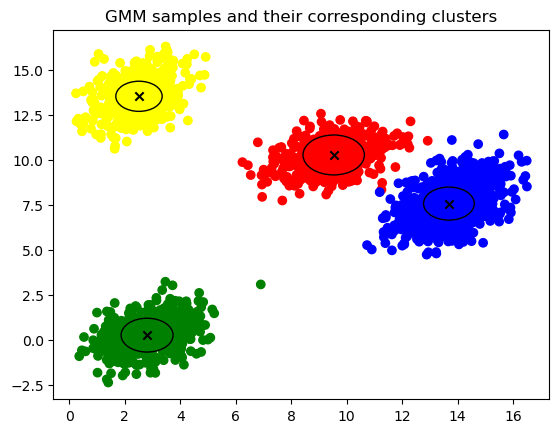

In [96]:
colors = ['red', 'blue', 'green', 'yellow']
colors_samples = [colors[cluster] for cluster in clusters]

# Plot the samples with colors
plt.scatter([x[0] for x in samples], [x[1] for x in samples], c=colors_samples)
# Plot the means of the clusters
plt.scatter([x[0] for x in liste_mu], [x[1] for x in liste_mu], c='black', marker='x')

#plot a circle for each cluster
for i in range(num_classes):
    circle = plt.Circle(liste_mu[i], np.sqrt(liste_sigma[i][0, 0]), color='black', fill=False)
    plt.gca().add_artist(circle)
plt.title('GMM samples and their corresponding clusters')

Text(0.5, 1.0, 'Generated samples according to the estimated parameters and their corresponding clusters')

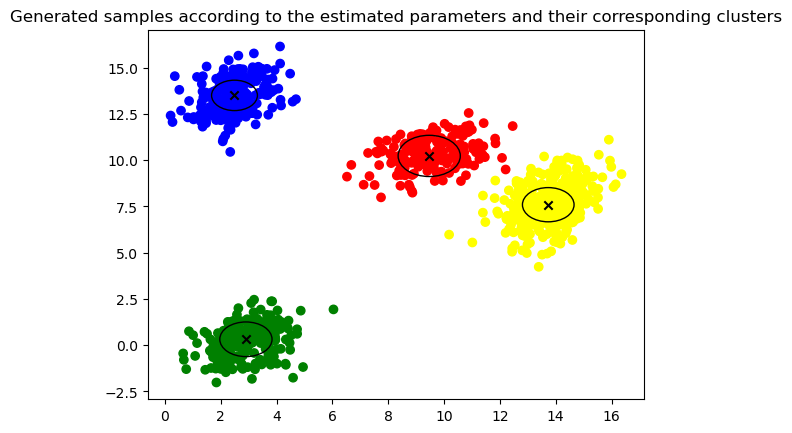

In [97]:
#Artificial samples
num_classes = 4
n_samples = 1000
 
art_samples, art_clusters = samples_GMM(n_samples, alpha, mu, sigma)

# Assign colors based on clusters
art_colors = ['red', 'blue', 'green', 'yellow']
art_colors_samples = [art_colors[cluster] for cluster in art_clusters]

# Plot the samples with colors
plt.scatter([x[0] for x in art_samples], [x[1] for x in art_samples], c=art_colors_samples)

# Plot the means of the clusters
plt.scatter([x[0] for x in theta_hat[0][1]], [x[1] for x in theta_hat[0][1]], c='black', marker='x')
#plot a circle for each cluster
for i in range(num_classes):
    circle = plt.Circle(theta_hat[0][1][i], np.sqrt(theta_hat[0][2][i][0, 0]), color='black', fill=False)
    plt.gca().add_artist(circle)
plt.title('Generated samples according to the estimated parameters and their corresponding clusters')

The estimated distribution fits the original distribution.

## 5

### Get the data

In [98]:
import pandas as pd
from tqdm import tqdm 

In [99]:
df = pd.read_csv("WPP2024_Demographic_Indicators_Medium.csv").dropna()
X = np.stack([df["CBR"].values,df["CDR"].values],axis=-1)

/var/folders/8r/j32fdl9577757zwhgtdsbrpr0000gn/T/ipykernel_4768/1218479672.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("WPP2024_Demographic_Indicators_Medium.csv").dropna()


### Plot

Text(0.5, 1.0, 'CBR vs CDR')

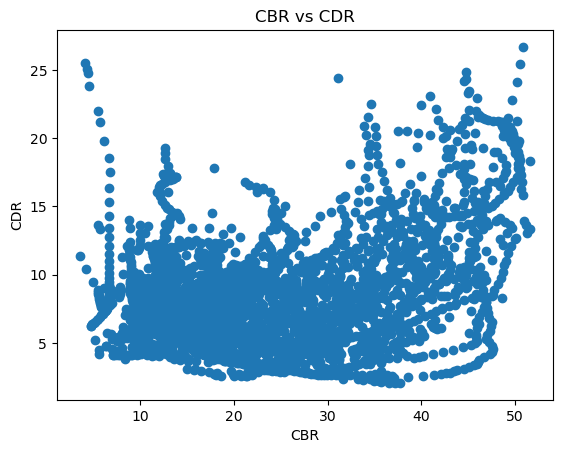

In [100]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel('CBR')
plt.ylabel('CDR')
plt.title('CBR vs CDR')

We could try to fit a GMM, as there seems to be 3 clusters ; areas with a low CDR and a low CBR, areas with a low CDR and an important CBR and areas with both CDR and CBR being important.  

Text(0.5, 1.0, 'Normalized CBR vs CDR')

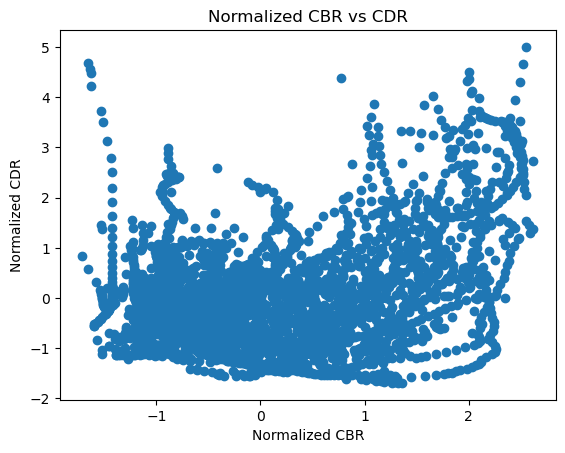

In [101]:
# We will use a normalized version of the data
X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

plt.scatter(X_normalized[:,0],X_normalized[:,1])
plt.xlabel('Normalized CBR')
plt.ylabel('Normalized CDR')
plt.title('Normalized CBR vs CDR')

## Fit of a GMM for different number of thresholds

In [102]:
n_clusters = range(1, 7)
log_likelihoods = []
theta_hats = []

In [103]:
for i, n in enumerate(n_clusters):
    alpha_0 = np.array(np.random.uniform(0.1, 0.5, n))
    alpha_0 /= np.sum(alpha_0) 
    mu_0 = np.array([np.random.rand(2) * 15 for _ in range(n)])  
    sigma_0 = np.array([generate_covariance_matrix(2) for _ in range(n)]) 
    theta_0 = [alpha_0, mu_0, sigma_0]

    EM =  EM_algorithm(X_normalized, 25, theta_0)
    
    theta_hats.append(EM[0])
    log_likelihoods.append(EM[1])

In [104]:
for p in range(len(n_clusters)):
    alphas = theta_hats[p][0]
    print('Estimated alphas for', n_clusters[p], 'clusters:', alphas)

Estimated alphas for 1 clusters: [1.]
Estimated alphas for 2 clusters: [2.60010176e-04 9.99739990e-01]
Estimated alphas for 3 clusters: [2.60010216e-04 1.04006255e-03 9.98699927e-01]
Estimated alphas for 4 clusters: [2.60008533e-04 2.62319889e-03 1.07222893e-02 9.86394503e-01]
Estimated alphas for 5 clusters: [2.95706524e-14 2.59781880e-04 2.34602033e-03 7.66250218e-01
 2.31143980e-01]
Estimated alphas for 6 clusters: [2.78494340e-01 5.13300985e-08 2.59928176e-04 8.35840385e-16
 7.21245680e-01 4.84536154e-14]


/var/folders/8r/j32fdl9577757zwhgtdsbrpr0000gn/T/ipykernel_4768/318918055.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_normalized[:,1], X_normalized[:,0], cmap='viridis', alpha=0.5)


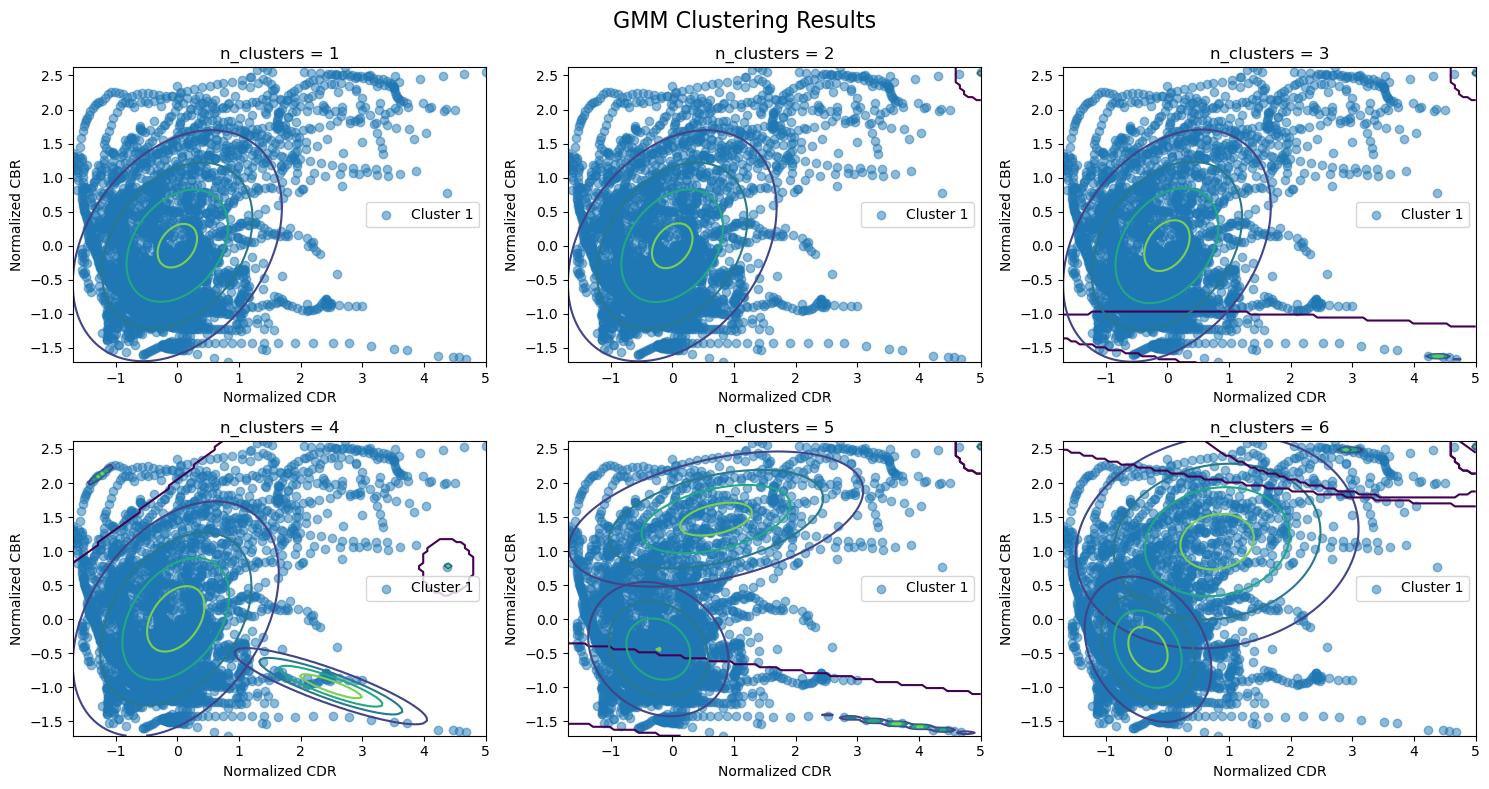

In [105]:
fig, axes = plt.subplots(2, len(n_clusters)//2, figsize=(15, 8))

grid_x, grid_y = np.mgrid[min(X_normalized[:,0]):max(X_normalized[:,0]):100j, min(X_normalized[:,1]):max(X_normalized[:,1]):100j]

for i, n in enumerate(n_clusters):
    row = i // (len(n_clusters)//2)
    col = i % (len(n_clusters)//2)
    ax = axes[row, col]
    ax.scatter(X_normalized[:,1], X_normalized[:,0], cmap='viridis', alpha=0.5)
    ax.set_title('n_clusters = {}'.format(n))
    for j in range(n):
        mu_p = theta_hats[i][1][j]
        sigma_p = theta_hats[i][2][j]
        Z_component = np.zeros_like(grid_x)
        for k in range(grid_x.shape[0]):
            for l in range(grid_x.shape[1]):
                x_point = np.array([grid_x[k, l], grid_y[k, l]])
                Z_component[k, l] = multivariate_normal.pdf(x_point, mu_p, sigma_p)
        ax.contour(grid_y, grid_x, Z_component, levels=4)
    ax.legend(['Cluster {}'.format(j+1) for j in range(n)])
    ax.set_xlabel('Normalized CDR')
    ax.set_ylabel('Normalized CBR')

fig.suptitle('GMM Clustering Results', fontsize=16)
plt.tight_layout()
plt.show()


The existence of outliers makes it hard for the model to fit a GMM. In particular, the points with low CBR and high CDR shatter the model. 

### BIC estimation

In [106]:
def BIC(samples, theta_hat):
    log_likelihood = compute_log_likelihood(samples, theta_hat[0], theta_hat[1], theta_hat[2])
    n_samples = len(X)
    n_clusters = len(theta_hat[0])
    d = X.shape[1]
    return -log_likelihood + (n_clusters * (d + 1) * (d/2.0 + 1)) * np.log(n_samples) / 2.0

In [107]:
for i, theta in enumerate(theta_hats):
    print(f'For {n_clusters[i]} clusters, the BIC is:', BIC(X_normalized, theta))

For 1 clusters, the BIC is: 10719.490981682575
For 2 clusters, the BIC is: 10731.336343272076
For 3 clusters, the BIC is: 10702.109670893351
For 4 clusters, the BIC is: 10667.672224454906
For 5 clusters, the BIC is: 9718.325487328004
For 6 clusters, the BIC is: 9813.248838977455


The data seems to be best modeled by a GMM with 5 clusters. 

# Exercise 3

## A - 

In [108]:
def f(x):
    return 2*np.sin(np.pi/1.5*x)*(x>=0)

def p(x):
    return x**(0.65)*np.exp(-0.5*x**2)*(x>=0)

def q(x, mu):
    return 2 / np.sqrt(2 * np.pi * 1.5) * np.exp(-((mu - x)**2) / (2 * 1.5))

In [109]:
def importance_sampling(p, mu, f, n_samples):
    'Estimates E_p[g(X)]'
    samples = 2*np.random.normal(mu, 1.5, n_samples)
    samples = samples[samples >= 0]
    n_samples = len(samples)
    weights = p(samples)/(q(samples, mu))
    mean = np.mean(weights*f(samples))/n_samples
    return mean

In [110]:
Ns = [10, 100, 1000, 10000]

for n_samples in Ns:
    liste = []
    for _ in range(100):
        liste.append(importance_sampling(p, 0.8, f, n_samples))
    print('Number of samples:', n_samples, 'Mean:', np.mean(liste), 'Standard deviation:', np.std(liste))

Number of samples: 10 Mean: 0.021093581480568783 Standard deviation: 0.044118044196988504
Number of samples: 100 Mean: 0.0025031288317808238 Standard deviation: 0.001283749905458075
Number of samples: 1000 Mean: 0.0002488615157784835 Standard deviation: 4.118373434127481e-05
Number of samples: 10000 Mean: 2.423680053773123e-05 Standard deviation: 1.086686015182066e-06


### Shifting $\mu$

In [111]:
for n_samples in Ns:
    liste = []
    for _ in range(100):
        liste.append(importance_sampling(p, 6, f, n_samples))
    print('Number of samples:', n_samples, 'Mean:', np.mean(liste), 'Standard deviation:', np.std(liste))

Number of samples: 10 Mean: -8.031151635417491e-06 Standard deviation: 0.000340350193991714
Number of samples: 100 Mean: 0.0388271427445187 Standard deviation: 0.39250627167379576
Number of samples: 1000 Mean: 0.0018836729614895619 Standard deviation: 0.008436958755969568
Number of samples: 10000 Mean: 0.00022683483420720524 Standard deviation: 0.0002573530451235617


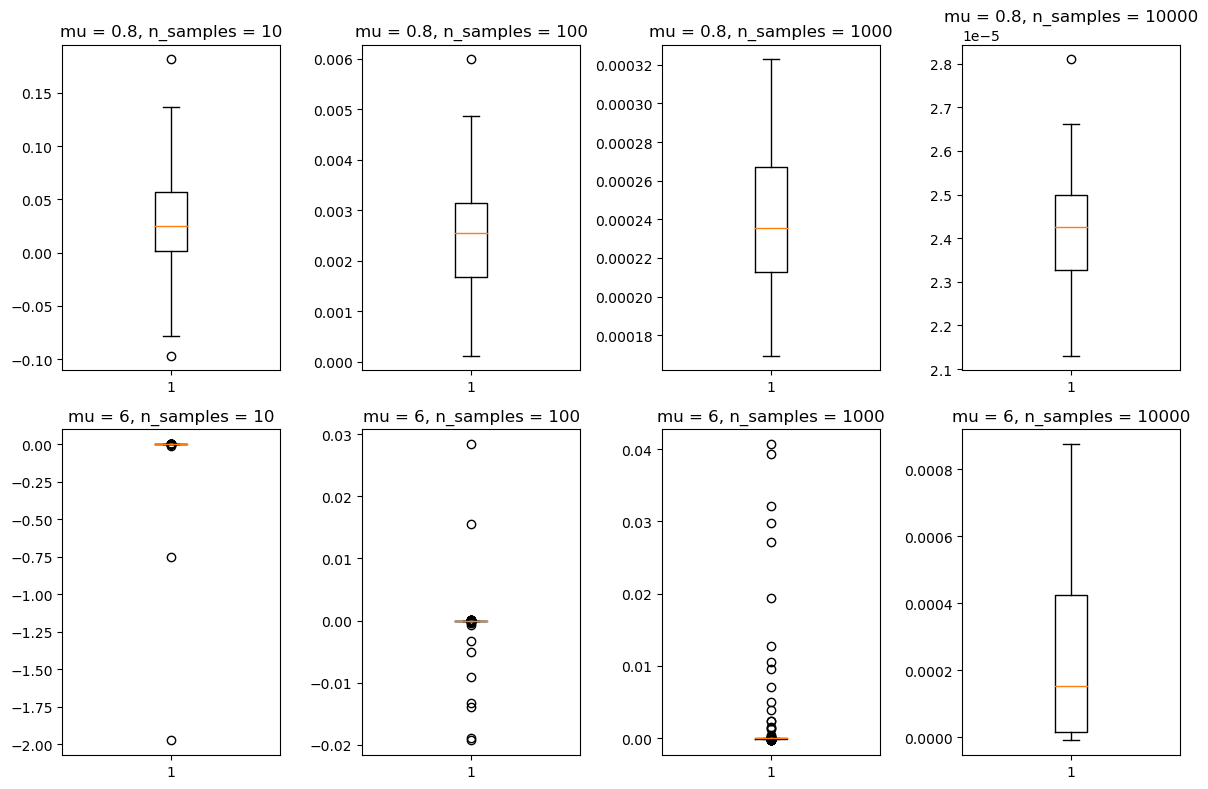

In [112]:
mus = [0.8, 6]
Ns = [10, 100, 1000, 10000]

fig, axes = plt.subplots(len(mus), len(Ns), figsize=(12, 8))

for i, mu in enumerate(mus):
    for j, n_samples in enumerate(Ns):
        liste = []
        for _ in range(100):
            liste.append(importance_sampling(p, mu, f, n_samples))
        axes[i, j].boxplot(liste)
        axes[i, j].set_title('mu = ' + str(mu) + ', n_samples = ' + str(n_samples))

plt.tight_layout()
plt.show()


When the centers of mass of $p$ and $q$ are far appart, the Kullback-Leiber divergence of the two distributions is important. The importance sampling is therefore less stable and yields far more outliers (see $\mu = 6$ and $n_{samples} = 1000$ for instance). Poor importance sampling's results are strongly dependant on the choice of the importance density $q$, which is why we prefer the following Adaptative Importance Sampling. 

## B  - 

See handwritten notes

## C - Application to banana-shaped density

In [113]:
from tqdm import tqdm

In [114]:
def nu(x, d=5, sigma1 = 1, b=0.4):
    'Target distribution'

    x = np.array(x)
    mu = np.zeros(d)
    cov = np.eye(d)
    cov[0, 0] = sigma1**2
    for a in x:
        a[1] += b*(a[0]**2 - sigma1**2)
    mul = multivariate_normal.pdf(x, mean=mu, cov=cov)
    return mul

In [116]:
# rappel : samples_GMM(n_samples, liste_pi, liste_mu, liste_sigma) samples n_samples from a Gaussian Mixture Model'
def samples_GMM_(n_samples, theta):
    return samples_GMM(n_samples, theta[0], theta[1], theta[2])

def GMM_density(x, theta):
    'GMM density in x'
    pi, mu, sigma = theta[0], theta[1], theta[2]
    density = 0
    for k in range(len(pi)):
        density += pi[k] * multivariate_normal.pdf(x, mean=mu[k], cov=sigma[k])
    return density

In [157]:
def EM_PMC(samples, n_iter_EM, n_clusters, weights, theta_0): 
    samples = np.array(samples)
    n_samples, d = samples.shape

    alpha_0, mu_0, sigma_0 = theta_0[0], theta_0[1], theta_0[2]
    n_clusters = len(alpha_0)
    pij = np.zeros((n_samples, n_clusters))

    alpha_hat = alpha_0
    mu_hat = mu_0
    sigma_hat = sigma_0
    theta_hat = [alpha_hat, mu_hat, sigma_hat]
    
    for _ in range(n_iter_EM):
        # Step E
        for i in range(n_samples):
            for j in range(n_clusters):
                pij[i,j] = alpha_hat[j] * multivariate_normal.pdf(samples[i], mean=mu_hat[j], cov=sigma_hat[j])
            pij[i,:] /= np.sum(pij[i,:])
            pij[i,:] *= weights[i]

        # Step M
        N_k = np.sum(pij, axis=0)
        sum_nk = np.sum(N_k)
        alpha_hat = N_k / sum_nk
        mu_hat = np.dot(pij.T, samples) / N_k[:, None]
        for j in range(n_clusters):
            sigma_hat[j] = np.dot(pij[:, j] * (samples - mu_hat[j]).T, samples - mu_hat[j]) / N_k[j]
            sigma_hat[j] += 1e-4 * np.eye(d)
        
    return [alpha_hat, mu_hat, sigma_hat]


def PMC(n_iter_PMC, n_iter_EM, n_samples, n_clusters, theta_0):
    'Fits a GMM to the objective distribution using the PMC algorithm'
    theta_hat = theta_0

    for iter_num in tqdm(range(n_iter_PMC)):
        samples = samples_GMM_(n_samples, theta_hat)[0]
        w_i = nu(samples)/GMM_density(samples, theta_hat) 
        w_i_mean = np.mean(w_i)
        #print('Mean of weights:', w_i_mean)
        w_i /= w_i_mean  # weights w_i tilde
        theta_hat = EM_PMC(samples, n_clusters, n_iter_EM, w_i, theta_hat)
    
    return theta_hat

In [158]:
# Fit a GMM to the objective distribution using the PMC algorithm
num_clusters = 4
d=5

alpha_0 = np.array(np.random.uniform(0.1, 0.5, 4))
alpha_0 /= np.sum(alpha_0)
mu_0 = np.array([np.random.rand(d) * 0.5 for _ in range(num_clusters)])
sigma_0 = np.array([generate_covariance_matrix(d) for _ in range(num_clusters)])
theta_0 = [alpha_0, mu_0, sigma_0]

theta = PMC(50, 20, 1000, num_clusters, theta_0)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


We can now sample the distribution: 

Text(0.5, 1.0, 'Samples from the target distribution')

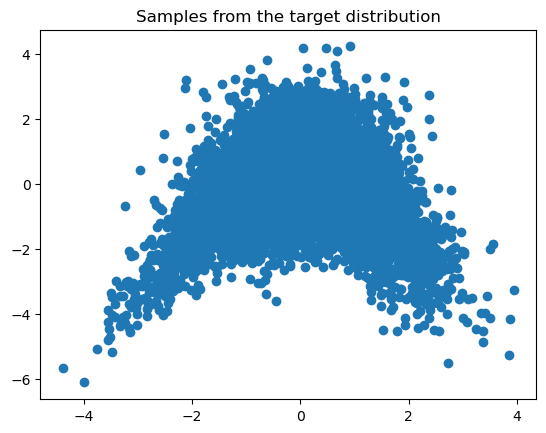

In [159]:
banana_samples = samples_GMM(10000, theta[0], theta[1], theta[2])[0]

plt.scatter([x[0] for x in banana_samples], [x[1] for x in banana_samples])
plt.title('Samples from the target distribution')


The distribution we obtain is indeed slightly resembling a banana! 